In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
#import shap
import pickle
#from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
#from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
import os
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier
#from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
#from sklearn.neural_network import MLPClassifier
import catboost
from catboost import *
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")


sns.set_theme(style="whitegrid")
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']


In [2]:
# Load and process data function
def dataloader(filepath):
    raw_data = pd.read_csv(filepath)
    med_columns = raw_data.columns[raw_data.columns.str.contains('Med_')]
    raw_data[med_columns] = raw_data[med_columns].fillna(0)
    columns_to_rename = raw_data.columns[65:273]
    new_column_names = [col.rsplit('_', 1)[0] for col in columns_to_rename]
    raw_data.rename(columns=dict(zip(columns_to_rename, new_column_names)), inplace=True)
    filtered_df = raw_data[raw_data['Is transferred to ICU'] == 1].drop('Is transferred to ICU', axis=1, errors='ignore')
    transform_dtypes_data = filtered_df.copy().iloc[:, 2:]
    category_columns_1 = transform_dtypes_data.columns[
        transform_dtypes_data.columns.str.contains('Med_') | transform_dtypes_data.columns.str.startswith('Diagnosis_')
    ]
    transform_dtypes_data[category_columns_1] = transform_dtypes_data[category_columns_1].applymap(lambda x: 0 if x == 0.0 else 1)
    category_columns_2 = ['Gender', 'Insurance', 'Race', 'triage_Acuity', 'Arrival transport']
    transform_dtypes_data[category_columns_1] = transform_dtypes_data[category_columns_1].astype('category')
    transform_dtypes_data[category_columns_2] = transform_dtypes_data[category_columns_2].astype('category')
    # print(transform_dtypes_data.dtypes)

    def remove_outliers(df):
        for column in df.columns:
            if pd.api.types.is_numeric_dtype(df[column]):
                lower_bound = df[column].quantile(0.01)
                upper_bound = df[column].quantile(0.99)
                df[column] = df[column].apply(lambda v: lower_bound if v < lower_bound else upper_bound if v > upper_bound else v)
            if column == 'Age':
                df[column] = df[column].apply(lambda v: 91 if v > 91 else v)
        return df
    
    data = remove_outliers(transform_dtypes_data)
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1].squeeze()  # Ensure y is a 1D Series
    return X, y

# Feature selection function
def select_features(X, selected_features):
    print(f'Selected feature count: {len(selected_features)}')
    return X[selected_features]

In [3]:
cd = '/Users/hnwang/bmc/ihm_icu/' 
search_path = cd + '/fs_corr_step1/'
save_path = cd +'/fs_imp_step2-1/ML_models_compare/'

raw_data_path = '/Users/hnwang/ihm/without_fillna/alldata.csv'
X, y = dataloader(raw_data_path)

fs1 = pd.read_excel('/Users/hnwang/bmc/ihm_icu/fs_corr_step1' + '/significantPvalue_ihm.xlsx') #encoding_errors='ignore',,encoding="utf-8"
selected_features=fs1['ID'].tolist()
X_fs1 = select_features(X, selected_features)

Selected feature count: 168


## step 1: get topK importance trend

In [12]:

import pandas as pd
import numpy as np


## input data
cd = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2/' 
search_path1 = cd + '/get_4treeModels_weight_importance/'
search_path2 = cd + '/get_4treeModels_shap_importance/'
save_path = cd +'/get_topK_importance_trend/'

methods = ['LightGBM','XGBoost','Catboost']
#methods = ['LightGBM']

K = 168 # top K


##### functions
def normalize_dataframe(df):
    min_vals = df.min(axis=1)
    max_vals = df.max(axis=1)
    normalized_df = df.sub(min_vals, axis=0).div(max_vals.sub(min_vals, axis=0), axis=0)    
    return normalized_df

 
    
def get_data_SHAP(method):
    data0 = pd.read_csv(search_path2+method+'/importances_'+method+'.csv',index_col=0)
    data = normalize_dataframe(data0) 
    mean_values = data.mean(axis=0) 
    std_values = data.std(axis=0)
    df0 = pd.DataFrame({'meanvalue':mean_values,'stdvalue':std_values}) 
    df1 = df0.sort_values(by='meanvalue',ascending=False).reset_index(drop=False).rename(columns={'index':'Name'}) 
    df = df1.loc[:K,:]
    return df



def get_data_weight(method):
    data0 = pd.read_csv(search_path1+method+'/importances_'+method+'.csv',index_col=0)
    data = normalize_dataframe(data0)   
    mean_values = data.mean(axis=0) 
    std_values = data.std(axis=0)
    df0 = pd.DataFrame({'meanvalue':mean_values,'stdvalue':std_values}) 
    df1 = df0.sort_values(by='meanvalue',ascending=False).reset_index(drop=False).rename(columns={'index':'Name'})
    df = df1.loc[:K,:]           
    return df



#method = methods[0]
df1 = get_data_SHAP(methods[0]) 
df1.to_csv(save_path+'LightGBM_SHAP_imp.csv',index=False)
#
df2 = get_data_SHAP(methods[1])
df2.to_csv(save_path+'XGBoost_SHAP_imp.csv',index=False)
    
df3 = get_data_SHAP(methods[2]) 
df3.to_csv(save_path+'Catboost_SHAP_imp.csv',index=False)   
    
df4 = get_data_weight(methods[0])
df4.to_csv(save_path+'LightGBM_imp.csv',index=False)

df5 = get_data_weight(methods[1])  
df5.to_csv(save_path+'XGBoost_imp.csv',index=False)
  
df6 = get_data_weight(methods[2])   
df6.to_csv(save_path+'Catboost_imp.csv',index=False)
#  
 
    

**Step 2: Calculate the AUROC trend**
- **Description**: Progressively include features based on their importance rankings to calculate the AUROC trend. This iterative analysis determines the impact of each feature on the model's performance.
- **Execution Note**: This process is computationally intensive and can be time-consuming; running the code in a shell environment is recommended.
- **Output**: Results, including the AUROC's 95% confidence intervals, are saved in files named `{method}_auc_95CI_trend.csv` for each evaluation method.

---

```python
### get the auc 95%CI, 
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import utils
from joblib import Parallel, delayed
import lightgbm as lgb
#import shap
from sklearn.model_selection import StratifiedKFold
import xgboost
import os
from sklearn.metrics import precision_recall_fscore_support
import catboost
from catboost import *
import warnings
warnings.filterwarnings('ignore')

## input data
cd = '/home/wanghongnian/repositories/ihm_icu/' 
search_path = cd + '/fs_auc_step2-2/get_topK_importance_trend/'
save_path = cd +'/fs_auc_step2-2/get_topK_auc_trend/'

## 

methods = ['LightGBM_SHAP','XGBoost_SHAP','Catboost_SHAP','LightGBM','XGBoost','Catboost']

X, y = X_fs1, y


log = open(save_path+'/log_results.txt',mode="a+",encoding="utf-8")
############ function ##########################################
 

def model_10cv_XGBoost(X,y):
    #import xgboost
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=10)#, random_state=0
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        D_train = xgboost.DMatrix(X_train,label=y_train, enable_categorical=True)
        D_test = xgboost.DMatrix(X_test,label=y_test, enable_categorical=True)
        ###
        params = {
            "eta": 0.01,
            "booster": "gbtree",
            "objective": "binary:logistic",
            "eval_metric":"auc",
            "min_child_weight": 150,
        }
        steps = 1000  # The number of training iterations
        model = xgboost.train(params, D_train, steps, verbose_eval=False)#
        y_tepred = model.predict(D_test)
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====XGBoost model: meanAUC={}'.format(meanAUC))
    print('====XGBoost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    print('====XGBoost model: meanAUC={}'.format(meanAUC),file=log)
    print('====XGBoost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY})
    ''' 
    if os.path.exists(save_path+'/XGBoost/')==False:
        os.makedirs(save_path+'/XGBoost/')
    predict_result.to_csv(save_path+'/XGBoost/predict_result_XGBoost.csv',index=False) 
    '''   
    return predict_result    


#predict_result = model_10cv_XGBoost(X,y)


def model_10cv_LightGBM(X,y):
    #import lightgbm as lgb
    #from sklearn.model_selection import StratifiedKFold
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=10)#, random_state=0
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        d_train = lgb.Dataset(X_train,label=y_train)
        d_test = lgb.Dataset(X_test,label=y_test)
        ###
        params = {
            "learning_rate": 0.01,
            "boosting_type": "gbdt",
            "objective": "binary",
            "metric": ['auc', 'binary_logloss'],
            'max_depth': 5,
            'verbosity': -1,
        }
        model = lgb.train(params, d_train, 1000)
        y_tepred = model.predict(X_test, num_iteration=model.best_iteration)
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====LightGBM model: meanAUC={}'.format(meanAUC))
    print('====LightGBM model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    print('====LightGBM model: meanAUC={}'.format(meanAUC),file=log)
    print('====LightGBM model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY})
    ''' 
    if os.path.exists(save_path+'/LightGBM/')==False:
        os.makedirs(save_path+'/LightGBM/')
    predict_result.to_csv(save_path+'/LightGBM/predict_result_LightGBM.csv',index=False) 
    '''   
    return predict_result    

#predict_result = model_10cv_LightGBM(X,y)  


def model_10cv_Catboost(X,y):
    #import catboost
    #from catboost import *
    #from sklearn import metrics
    skf = StratifiedKFold(n_splits=10)
    cat_features = X.select_dtypes(['category']).columns.tolist()
    model = CatBoostClassifier(iterations=1000, learning_rate=0.01, cat_features=cat_features, verbose=0)
    ## note X,y is dataFrame, not array, so .split(X,y) is not right
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)        
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
    meanAUC = np.mean(allAUC)
    print('====Catboost model: meanAUC={}'.format(meanAUC))
    print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5))) 
    print('====Catboost model: meanAUC={}'.format(meanAUC),file=log)
    print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)),file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY})
    ''' 
    if os.path.exists(save_path+'/Catboost/')==False:
        os.makedirs(save_path+'/Catboost/')
    predict_result.to_csv(save_path+'/Catboost/predict_result_Catboost.csv',index=False)
    '''      
    return predict_result    

#predict_result = model_10cv_Catboost(X,y)



def get_auc_95CI(y_true,y_score,n):
    # n is .nf e.g., .3f, .2f
    #from sklearn import metrics
    #from sklearn import utils
    #from joblib import Parallel, delayed      
    def bootstrap_roc_func(i, y_true, y_score):
        yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
        return metrics.roc_curve(yte_true_b, yte_pred_b), metrics.roc_auc_score(yte_true_b, yte_pred_b)

    def get_roc_CI(y_true, y_score,n):
        roc_curves, auc_scores = zip(*Parallel(n_jobs=15)(delayed(bootstrap_roc_func)(i, y_true, y_score) for i in range(100)))    
        # roc_curves, auc_scores = [], []
        # for i in range(1000):
        #     yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
        #     roc_curves.append(metrics.roc_curve(yte_true_b, yte_pred_b))
        #     auc_scores.append(metrics.roc_auc_score(yte_true_b, yte_pred_b))                       
        print('Test ROC AUC: {:.3f}'.format(metrics.roc_auc_score(y_true, y_score)))
        print('Test ROC AUC: ({:.3f}, {:.3f}) percentile 95% CI'.format(np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))   
        meanAUC  = np.round(metrics.roc_auc_score(y_true, y_score),n)
        uCI = np.round(np.percentile(auc_scores, 97.5),n)
        dCI = np.round(np.percentile(auc_scores, 2.5),n)
        #roauc_std = np.std(auc_scores)        
        #auc_ROC = {'roc_auc':roauc,'roc_auc_CI':[roauc_dCI,roauc_uCI],'roc_curves':roc_curves} 
        #allAUC = str(meanAUC)+'['+str(dCI)+', '+str(uCI)+']'       
        return meanAUC, dCI, uCI       
    meanAUC, dCI, uCI = get_roc_CI(y_true, y_score,n)        
    return meanAUC, dCI, uCI
    





#################
def main_function(X,y,method,k,n):
    ## get feature name based on the top k feature
    imp = pd.read_csv(search_path+method+'_imp.csv')
    ind = imp.loc[:k,'Name']
    XX = X.loc[:,ind]
    if method in ['LightGBM_SHAP','LightGBM']:    
        predict_result = model_10cv_LightGBM(XX,y)  #predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY})
    elif method in ['XGBoost_SHAP','XGBoost']:
        predict_result = model_10cv_XGBoost(XX,y)
    elif method in ['Catboost_SHAP','Catboost']:
        predict_result = model_10cv_Catboost(XX,y) 
    else:
        print('Wrong input!!!')             
    meanAUC, dCI, uCI = get_auc_95CI(predict_result['y_test'],predict_result['y_tepred'],n)
    print('====== k=%d, auc=%.3f ' %(k,meanAUC))
    return meanAUC, dCI, uCI





n = 3 #.3f
#method = methods[0]

def main(method):
    # for 48hr
    allAUC = []
    alluCI = []
    alldCI = []
    ##
    rg = list(range(1,160+1)) #important len is 400
    for k in rg:
        print('=============== k=%d ============='%(k))
        meanAUC, dCI, uCI = main_function(X,y, method,k,n)
        allAUC.append(meanAUC)
        alluCI.append(uCI)
        alldCI.append(dCI)
    ##    
    df = pd.DataFrame({'topK':rg,'meanAUC':allAUC,'dCI':alldCI,'uCI':alluCI})
    df.to_csv(save_path+method+'_auc_95CI_trend.csv',index=False)


for method in methods:
    main(method)



```

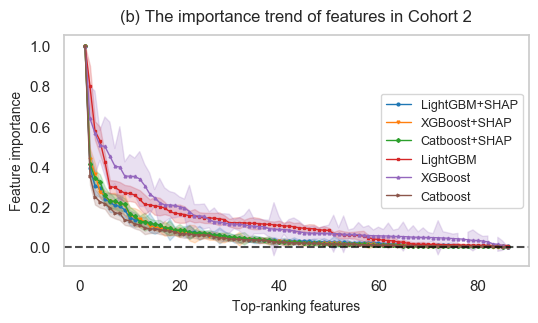

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

## input data
cd = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2/' 
search_path1 = cd + '/get_topK_importance_trend/'
search_path2 = cd + '/get_topK_auc_trend/'
save_path = cd +'/plot_importance_auc_trend/'

### Methods and styling
methods = ['LightGBM_SHAP', 'XGBoost_SHAP', 'Catboost_SHAP', 'LightGBM', 'XGBoost', 'Catboost']
methodsName = ['LightGBM+SHAP', 'XGBoost+SHAP', 'Catboost+SHAP', 'LightGBM', 'XGBoost', 'Catboost']
K = 86
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Colors for each method
markers = ['o', 'v', 'D', 's', '^', '>', '<']  # Markers for each method

def get_imp(method):
    temp = pd.read_csv(search_path1 + method + '_imp.csv')
    imp_data = temp[['meanvalue', 'stdvalue']]
    return imp_data

def get_auc(method):
    auc_data = pd.read_csv(search_path2 + method + '_auc_95CI_trend.csv')
    return auc_data

def get_data(method):
    imp_data = get_imp(method)
    auc_data = get_auc(method)
    x = auc_data['topK'][:K]
    imp_mean = imp_data['meanvalue'][:K]
    imp_std = imp_data['stdvalue'][:K]
    return x, imp_mean, imp_std

# Creating the main plots and insets
fig = plt.figure(figsize=(6, 3))
ax1 = plt.subplot(1, 1, 1)

# Plot each method
for i, method in enumerate(methods):
    x, imp_mean, imp_std = get_data(method)
    ax1.plot(x, imp_mean, marker=markers[i], linestyle='-', color=colors[i], lw=1, markersize=2, label=methodsName[i])
    ax1.fill_between(x, imp_mean - 1.96 * imp_std, imp_mean + 1.96 * imp_std, color=colors[i], alpha=0.2)
ax1.set_ylabel('Feature importance', fontsize=10)
ax1.set_title('(b) The importance trend of features in Cohort 2', fontsize=12, pad=10)
ax1.set_xlabel('Top-ranking features', fontsize=10)
ax1.axhline(y=0, linestyle='--', color='black', alpha=0.7)


# Add legend and adjust layout
ax1.legend(loc='center right', fontsize=9)
plt.grid(False)  # 关闭网格线
# plt.tight_layout()
plt.savefig(save_path + 'plot_imp_trend_MIMIC.png', dpi=300, bbox_inches='tight')
plt.show()

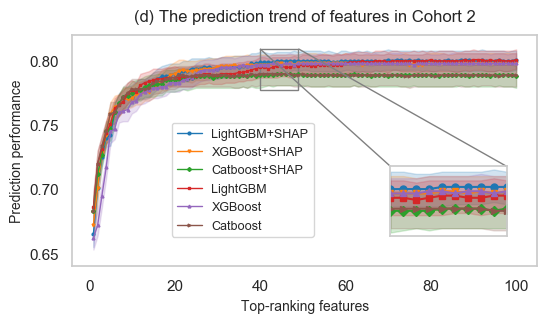

In [3]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

## input data
cd = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2/' 
search_path1 = cd + '/get_topK_importance_trend/'
search_path2 = cd + '/get_topK_auc_trend/'
save_path = cd + '/plot_imp_auc_trend_new/'

### Methods and styling
methods = ['LightGBM_SHAP', 'XGBoost_SHAP', 'Catboost_SHAP', 'LightGBM', 'XGBoost', 'Catboost']
methodsName = ['LightGBM+SHAP', 'XGBoost+SHAP', 'Catboost+SHAP', 'LightGBM', 'XGBoost', 'Catboost']

K = 100
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Colors for each method
markers = ['o', 'v', 'D', 's', '^', '>', '<']  # Markers for each method

def get_imp(method):
    temp = pd.read_csv(search_path1 + method + '_imp.csv')
    imp_data = temp[['meanvalue', 'stdvalue']]
    return imp_data

def get_auc(method):
    auc_data = pd.read_csv(search_path2 + method + '_auc_95CI_trend.csv')
    return auc_data

def get_data(method):
    imp_data = get_imp(method)
    auc_data = get_auc(method)
    x = auc_data['topK'][:K]
    imp_mean = imp_data['meanvalue'][:K]
    imp_std = imp_data['stdvalue'][:K]
    auc_mean = auc_data['meanAUC'][:K]
    auc_dci = auc_data['dCI'][:K]
    auc_uci = auc_data['uCI'][:K]
    return x, imp_mean, imp_std, auc_mean, auc_dci, auc_uci

# Creating the main plots and insets
fig = plt.figure(figsize=(6, 3))
ax2 = plt.subplot(1, 1, 1)

# Plot each method
for i, method in enumerate(methods):
    x, imp_mean, imp_std, auc_mean, auc_dci, auc_uci = get_data(method)
    ax2.plot(x, auc_mean, marker=markers[i], linestyle='-', color=colors[i], lw=1, markersize=2, label=methodsName[i])
    ax2.fill_between(x, auc_dci, auc_uci, color=colors[i], alpha=0.2)

ax2.set_ylim(0.64, 0.82)
ax2.set_ylabel('Prediction performance', fontsize=10)
ax2.set_title('(d) The prediction trend of features in Cohort 2', fontsize=12, pad=10)
ax2.set_xlabel('Top-ranking features', fontsize=10)

# Add an inset to the AUROC trend plot
ax2_inset = inset_axes(ax2, width="25%", height="30%", loc='lower right', borderpad=2)

# Loop over methods to plot in the inset
for i, method in enumerate(methods):
    _, _, _, auc_mean, auc_dci, auc_uci = get_data(method)
    x1, x2 = 40, 50
    x_zoom = range(x1, x2)
    y_zoom = auc_mean[x1-1:x2-1]
    yerr_lower = auc_dci[x1-1:x2-1]
    yerr_upper = auc_uci[x1-1:x2-1]
    ax2_inset.plot(x_zoom, y_zoom, marker=markers[i], linestyle='-', color=colors[i], lw=1.5, markersize=5)
    ax2_inset.fill_between(x_zoom, yerr_lower, yerr_upper, color=colors[i], alpha=0.2)

ax2_inset.set_xlim(x1, x2-1)
ax2_inset.set_xticks([])
ax2_inset.set_yticks([])

mark_inset(ax2, ax2_inset, loc1=1, loc2=2, fc="none", ec='0.5')

# Add legend and adjust layout
ax2.legend(loc='lower left', fontsize=9, bbox_to_anchor=(0.2, 0.1))  # 增加水平偏移
ax2.grid(False)
# plt.tight_layout()
plt.savefig(save_path + 'plot_auc_trend_MIMIC.png', dpi=300, bbox_inches='tight')
plt.show()

## Step 3: Compute Similarity Trend and Plot Similarity

In [20]:
import pandas as pd
import numpy as np

## Input data paths
cd = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2/plot_similarity_figures/' 
search_path = cd + 'step1_get_similarity_data/'
save_path = cd + 'step3_compute_similarity_trend/'

methods = ['LightGBM_shap', 'XGBoost_shap', 'Catboost_shap', 'LightGBM', 'XGBoost', 'Catboost']
K = 100  # top K

def get_data(method):
    """Load and prepare data for the given method."""
    data_path = os.path.join(search_path, f"{method}_imp.csv")
    data = pd.read_csv(data_path, header=None, names=['Name', 'value'])
    data.set_index('Name', inplace=True)
    data = data[data['value'] != 0]
    return data

def compute_similarity(set1, set2):
    """Calculate Jaccard similarity between two sets."""
    intersection = set1.intersection(set2)
    min_len = min(len(set1), len(set2))
    return len(intersection) / min_len if min_len > 0 else 0

def method_similarity(data1, data2, topk):
    """Compute similarity for the top k features."""
    top1 = data1.nlargest(topk, 'value').index
    top2 = data2.nlargest(topk, 'value').index
    return compute_similarity(set(top1), set(top2))

def get_topK_similarity(data1, data2, K):
    """Compute similarities for top 1 to top K features."""
    return [method_similarity(data1, data2, k+1) for k in range(K)]

def save_topK_similarity_all(methods, K):
    """Compute and save average similarity and standard deviation across all methods."""
    os.makedirs(save_path, exist_ok=True)  # Ensure save path exists
    for method in methods:
        data1 = get_data(method)
        all_similarities = []
        for other_method in methods:
            if method != other_method:
                data2 = get_data(other_method)
                similarities = get_topK_similarity(data1, data2, K)
                all_similarities.append(similarities)
        # Calculate average and std of similarities across top K for each method
        all_similarities = np.array(all_similarities)
        avg_similarities = np.mean(all_similarities, axis=0)
        std_similarities = np.std(all_similarities, axis=0)
        # Save results to CSV
        result = pd.DataFrame({
            'avg_similarity': avg_similarities,
            'std_similarity': std_similarities
        }, index=[f'top{k+1}' for k in range(K)])
        result_path = os.path.join(save_path, f"avg_std_topK_similarity_{method}.csv")
        result.to_csv(result_path)

save_topK_similarity_all(methods, K)

In [24]:
data = pd.read_csv(f"{search_path}avg_std_topK_similarity_{method}.csv", index_col=0)
data 


,avg_similarity,std_similarity
top1,0.800000,0.400000
top2,0.700000,0.400000
top3,0.666667,0.210819
top4,0.650000,0.254951
top5,0.760000,0.195959
...,...,...
top96,0.947434,0.034224
top97,0.947434,0.034224
top98,0.947434,0.034224
top99,0.947434,0.034224


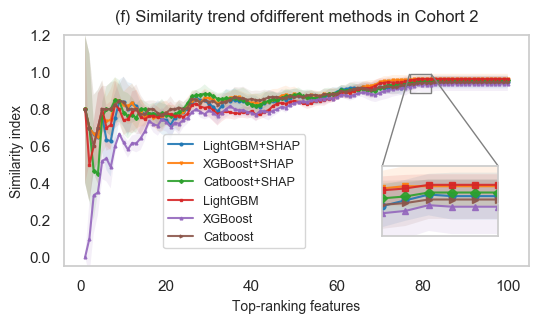

In [14]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

import seaborn as sns

sns.set_theme(style="whitegrid")

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

### Input data
cd = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2/plot_similarity_figures/' 
search_path = cd + '/step3_compute_similarity_trend/'
save_path = cd + '/step4_plot_similarity_trend/'

methods = ['LightGBM_shap', 'XGBoost_shap', 'Catboost_shap', 'LightGBM', 'XGBoost', 'Catboost']

#### Plot configuration
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']  # Colors for each method
markers = ['o', 'v', 'D', 's', '^', '>', '<']

# fig, ax = plt.subplots(figsize=(5.5, 3.5))
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 1, 1)

# Plot each method's average similarity trend with filled error bands
for i, method in enumerate(methods):
    data = pd.read_csv(f"{search_path}avg_std_topK_similarity_{method}.csv", index_col=0)
    x = range(1, len(data['avg_similarity']) + 1)
    y = data['avg_similarity']
    yerr = data['std_similarity']
    label_ = method.replace('_', '+').replace('shap', 'SHAP')  # Simplified label generation
    ax.plot(x, y, marker=markers[i], linestyle='-', color=colors[i], markersize=2, alpha=0.9, label=label_)
    ax.fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1, linewidth=0, edgecolor='none')

# Set main plot details
ax.set_ylim(-0.05,1.2)
ax.set_xlabel('Top-ranking features', fontsize=10)
ax.set_ylabel('Similarity index', fontsize=10)
ax.set_title('(f) Similarity trend ofdifferent methods in Cohort 2', fontsize=12, pad=10)
ax.legend(loc='lower left', fontsize=9, bbox_to_anchor=(0.2, 0.05))

# Add an inset plot for specified range, positioned at the lower right corner
ax_inset = inset_axes(ax, width="25%", height="30%", loc='lower right', borderpad=2)

for i, method in enumerate(methods):
    data = pd.read_csv(f"{search_path}avg_std_topK_similarity_{method}.csv", index_col=0)
    x1, x2 = 77, 83
    x = range(x1, x2)
    y = data['avg_similarity'].iloc[x1-1:x2-1]
    yerr = data['std_similarity'].iloc[x1-1:x2-1]
    ax_inset.plot(x, y, marker=markers[i], lw=1.5, markersize=5, color=colors[i], alpha=0.9)
    ax_inset.fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1, linewidth=0, edgecolor='none')

# Customize inset plot
ax_inset.set_xlim(x1, x2-1)
ax_inset.set_ylim(min(y - yerr) - 0.01, max(y + yerr) + 0.02)
ax_inset.set_xticks([])
ax_inset.set_yticks([])

mark_inset(ax, ax_inset, loc1=1, loc2=2, fc="none", ec='0.5')
ax.grid(False)
# plt.tight_layout()
plt.savefig(f"{save_path}plot_similarity_MIMIC.png", dpi=300, bbox_inches='tight')
plt.show()

## Step 4: Compute stability trend and plot stability

In [27]:
import pandas as pd
import numpy as np


## input data
cd = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2/'
search_path = cd + '/plot_stability_figures/step1-get stability/'
save_path = cd +'/plot_stability_figures/step3-compute stability index/'
os.makedirs(save_path, exist_ok=True)

methods = ['LightGBM', 'XGBoost', 'Catboost']
K = 100
threshold_value = 0.01

def get_data(shapORweight, method):
    """
    Load and preprocess data.
    """
    file_path = os.path.join(search_path, f"{method}_{shapORweight}_stability.csv")
    data = pd.read_csv(file_path, index_col=0)
    data.fillna(0, inplace=True)
    return data

def get_rank(data, maxORmin):
    """
    Rank data with the specified method for ranking.
    """
    ranks = data.apply(lambda x: x.rank(ascending=False, method=maxORmin), axis=0)
    return ranks

def threshold(data, threshold_value):
    """
    Apply threshold to data, setting values below threshold to zero.
    """
    return data.applymap(lambda x: x if x > threshold_value else 0)

def remove_zeros(series):
    """
    Remove zero entries from a pandas Series.
    """
    return series[series != 0].reset_index(drop=True)

def get_consistency(data1, data2, topk):
    """
    Calculate the consistency index between two datasets.
    """
    data11 = data1.rank(ascending=False, method='min')
    data22 = data2.rank(ascending=False, method='min')
    set1 = set(data11[data11 <= topk].index)
    set2 = set(data22[data22 <= topk].index)
    intersection = set1 & set2    
    union = set1 | set2
    consistency_index = len(intersection) / len(union)
    return consistency_index

def compute_stability(shapORweight, method, K):
    """
    Compute stability across all top K for given method and shapORweight.
    """
    data = get_data(shapORweight, method)
    data = threshold(data, threshold_value)
    all_topK = []
    for topk in range(1, K + 1):
        allic = []
        for i in range(data.shape[1] - 1):
            for j in range(i + 1, data.shape[1]):
                data1 = remove_zeros(data.iloc[:, i])
                data2 = remove_zeros(data.iloc[:, j])
                ic = get_consistency(data1, data2, topk)
                allic.append(ic)
        average_consistency = sum(allic) * 2 / (data.shape[1] * (data.shape[1] - 1))
        all_topK.append(average_consistency)
    return all_topK

for shapORweight in ['weight', 'shap']:
    for method in methods:
        all_topK = compute_stability(shapORweight, method, K)
        rt = pd.DataFrame([all_topK], index=['stability'], columns=[f'top{k+1}' for k in range(K)])
        rt.to_csv(os.path.join(save_path, f'topK_stability_{method}_{shapORweight}.csv'))        

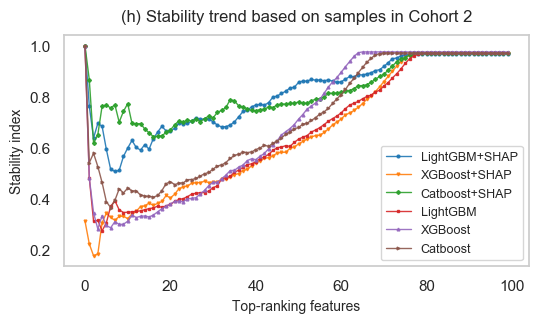

In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Define colors and markers for each method
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
markers = ['o', 'v', 'D', 's', '^', '>', '<']

### Input data
cd = '/Users/hnwang/bmc/ihm_icu/fs_auc_step2-2/plot_stability_figures/' 
search_path = cd + '/step3-compute stability index/'
save_path = cd + '/step4-plot stability trend figure/'
os.makedirs(save_path, exist_ok=True)

# Define the methods and read in data for each
methods = ['LightGBM', 'XGBoost', 'Catboost']
data_files = [f'/topK_stability_{method}_shap.csv' for method in methods] + \
             [f'/topK_stability_{method}_weight.csv' for method in methods]
data = [pd.read_csv(search_path + file, index_col=0) for file in data_files]

#### Plot
fig = plt.figure(figsize=(6, 3))
ax1 = plt.subplot(1,1,1)

# Plot each method with assigned colors and markers
for i, method_data in enumerate(data[:3]):
    ax1.plot(method_data.loc['stability', :].values, lw=1,markersize=2, color=colors[i], alpha=0.9, marker=markers[i],
             label=f'{methods[i]}+SHAP')
for i, method_data in enumerate(data[3:], start=3):
    ax1.plot(method_data.loc['stability', :].values,markersize=2, lw=1, color=colors[i], alpha=0.9, marker=markers[i],
             label=methods[i - 3])

# Configure the plot
ax1.set_xlabel('Top-ranking features', fontsize=10)
ax1.set_ylabel('Stability index', fontsize=10)
ax1.set_title('(h) Stability trend based on samples in Cohort 2', fontsize=12, pad=10)
ax1.legend(fontsize=9)

# Save and show the plot
# plt.tight_layout()
ax1.grid(False)
plt.savefig(save_path + '/plot_stability_MIMIC.png', dpi=300, bbox_inches='tight')
plt.show()

############
#plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=0.1, color=colors[0])
#x = [i+1 for i in range(len(mean_fpr))]
#plt.errorbar(x, data1.loc['mean', :].values, yerr=data1.loc['std', :].values, ecolor=colors[0], color=colors[0],
#             elinewidth=0.2, capsize=1, label='LightGBM') # fmt='s',